In [100]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

I will try to solve this classification problem using three techniques: 
* Logistic Regression (Different models)
* Classification Trees.
* Random Forests.

In [101]:
churning_data = pd.read_csv(r'https://raw.githubusercontent.com/wadihaleid/EmployeesChurnPrediction/master/Data/Data_Churn_Modelling.csv')
print(churning_data.shape)
print(churning_data.head)

(10000, 14)
<bound method NDFrame.head of       RowNumber  CustomerId    Surname  CreditScore Geography  Gender  Age  \
0             1    15634602   Hargrave          619    France  Female   42   
1             2    15647311       Hill          608     Spain  Female   41   
2             3    15619304       Onio          502    France  Female   42   
3             4    15701354       Boni          699    France  Female   39   
4             5    15737888   Mitchell          850     Spain  Female   43   
...         ...         ...        ...          ...       ...     ...  ...   
9995       9996    15606229   Obijiaku          771    France    Male   39   
9996       9997    15569892  Johnstone          516    France    Male   35   
9997       9998    15584532        Liu          709    France  Female   36   
9998       9999    15682355  Sabbatini          772   Germany    Male   42   
9999      10000    15628319     Walker          792    France  Female   28   

      Tenure    Balan

Set of functions to print model performance data , confusion matrix and to plot ROC curve. 
* Function **printConfusionMatrix** to print Confusion Matrix of statistical models.


In [102]:
def printConfusionMatrix (name , y_true , y_pred):    
    cm = confusion_matrix(y_true, y_pred).ravel()
    print (name)
    print ('==============================')
    print ("True Negatives : " + str(cm[0]))
    print ("True Positives : " + str(cm[3]))
    print ("False Positives : " + str(cm[1]))
    print ("False Negatives : " + str(cm[2]))
    print ('==============================')

* Function getModelPerformance to calculate performance measures of estimated models , such as (Specificity , Sensitivity , Accuracy , Precision , Recall , Mathew's Accuracy)
* Another function to print performance data.

In [103]:
def getModelPerformance (y_true , y_pred):
    cm = confusion_matrix(y_true, y_pred).ravel()    
    sensitivity = cm[3] / (cm[3] + cm[2])    
    specificity = cm[0] / (cm[0] + cm[1])
    accuracy = (cm[0] + cm[3]) / (cm[0] + cm[1] + cm[2] + cm[3])
    percision = cm[3] / (cm[3] + cm[1])
    recall = cm[3] / (cm[3] + cm[2])
    MCC = ((cm[3] * cm[0]) - (cm[1]*cm[2])) / (np.sqrt((cm[3] + cm[1]) * (cm[3] + cm[2]) * (cm[0] + cm[1]) * (cm[0] + cm[2])))
    return [sensitivity , specificity , accuracy , percision , recall , MCC ]

def printPerformanceData (name , p):
    print (name)    
    print ('==============================')
    print ("Sensitivity : " + str(p[0]))
    print ("Specificity : " + str(p[1]))
    print ("Accuracy : " + str(p[2]))    
    print ("Precision : " + str(p[3]) )
    print ("Recall : " + str(p[4]) )
    print ("Mathew Accuracy : " + str(p[5]))
    print ('==============================')


* Function to plot the ROC curve.


In [104]:
def plotLR_ROC (nsProb , lr_probs , y_test , X_test, modelName ):
    ns_probs = np.array([nsProb for _ in range(len(y_test))])        
    lr_fpr, lr_tpr , lr_thr = roc_curve(y_test, lr_probs)
    ns_fpr, ns_tpr , ns_thr = roc_curve(y_test, ns_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Null model')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=modelName)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


I start by visualizing the depended variable (Exited) against other independent variables in the dataset.


<Figure size 800x560 with 0 Axes>

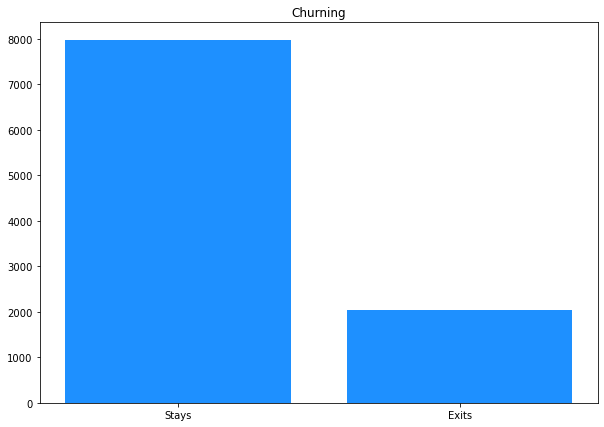

In [105]:
plt.figure(figsize=(10,7), dpi= 80)

exited_df = churning_data.groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()
fig, axs = plt.subplots(figsize=(10, 7))
axs.bar(exited_df['Exited'] , exited_df['total_number'] , color="dodgerblue") 
axs.set_title('Churning')
plt.xticks(exited_df['Exited'] , ('Stays' , 'Exits'))
plt.show()


From this barchart we can see that the data is imbalanced , more people stay than those who leave. This information is important when we build the logistic regression model , and this is the reason for using Mathew's accuracy in my performance measures set.

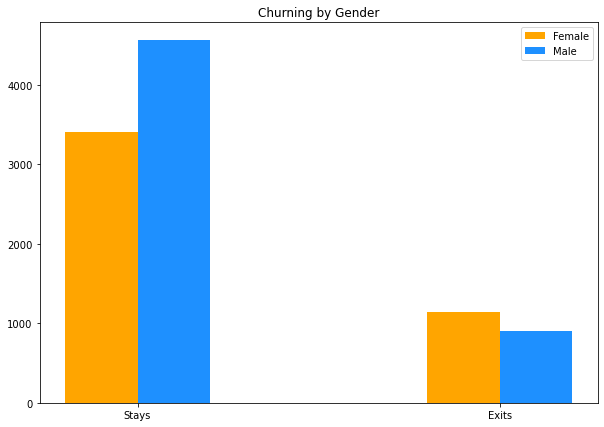

In [106]:
exit_females = churning_data.loc[churning_data.Gender == 'Female'].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()
exit_males = churning_data.loc[churning_data.Gender == 'Male'].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()

width = 0.2

fig, axs = plt.subplots(figsize=(10, 7))
axs.bar(exit_females['Exited'] - width/2 , exit_females['total_number'] , width , color="orange" , label='Female') 
axs.bar(exit_males['Exited'] + width/2 , exit_males['total_number'] , width ,  color="dodgerblue" , label='Male') 
axs.legend()
axs.set_title('Churning by Gender')
plt.xticks(exit_females['Exited'] , ('Stays' , 'Exits'))
plt.show()


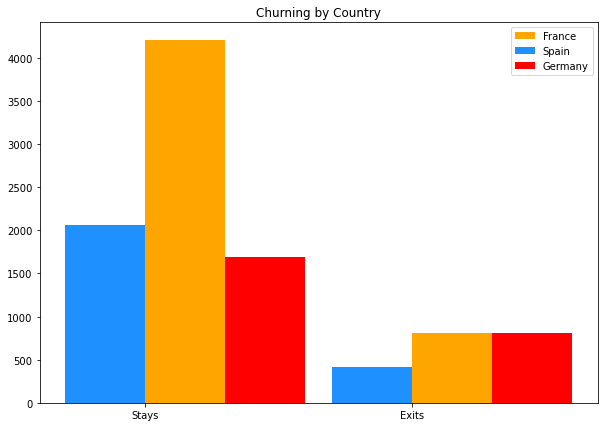

In [107]:
exit_france = churning_data.loc[churning_data.Geography == 'France'].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()
exit_spain = churning_data.loc[churning_data.Geography == 'Spain'].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()
exit_germany = churning_data.loc[churning_data.Geography == 'Germany'].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()

width = 0.3

fig, axs = plt.subplots(figsize=(10, 7))
axs.bar(exit_france['Exited'] + width/2 , exit_france['total_number'] , width , color="orange" , label='France') 
axs.bar(exit_spain['Exited'] - width/2, exit_spain['total_number'] , width ,  color="dodgerblue" , label='Spain') 
axs.bar(exit_germany['Exited'] + 1.5 * width , exit_germany['total_number'] , width ,  color="red" , label='Germany') 

axs.legend()
axs.set_title('Churning by Country')
plt.xticks(exit_females['Exited'] , ('Stays' , 'Exits'))
plt.show()

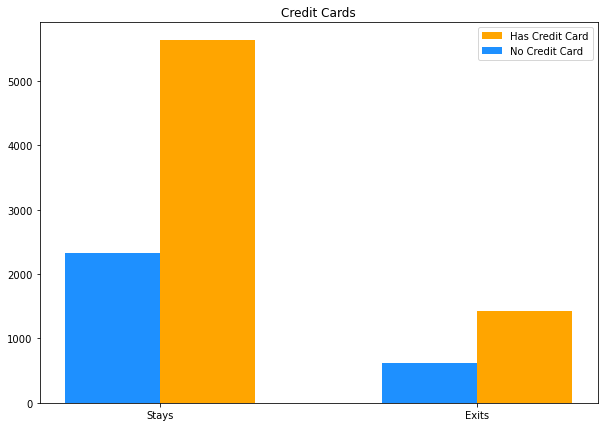

In [108]:
exit_hasCrCard = churning_data.loc[churning_data.HasCrCard == 1 ].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()
exit_NoCrCard = churning_data.loc[churning_data.HasCrCard == 0].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()

width = 0.3

fig, axs = plt.subplots(figsize=(10, 7))
axs.bar(exit_hasCrCard['Exited'] + width/2 , exit_hasCrCard['total_number'] , width , color="orange" , label='Has Credit Card') 
axs.bar(exit_NoCrCard['Exited'] - width/2, exit_NoCrCard['total_number'] , width ,  color="dodgerblue" , label='No Credit Card') 

axs.legend()
axs.set_title('Credit Cards')
plt.xticks(exit_females['Exited'] , ('Stays' , 'Exits'))
plt.show()


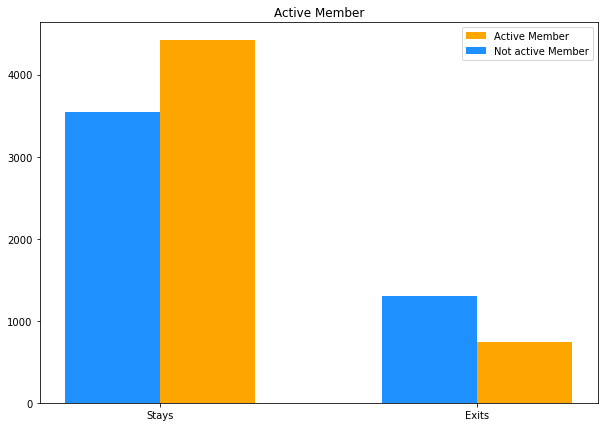

In [109]:
exit_IsActiveMember = churning_data.loc[churning_data.IsActiveMember == 1 ].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()
exit_NotActiveMember = churning_data.loc[churning_data.IsActiveMember == 0].groupby('Exited').agg(total_number = ('Exited' , 'count')).reset_index()

width = 0.3

fig, axs = plt.subplots(figsize=(10, 7))
axs.bar(exit_IsActiveMember['Exited'] + width/2 , exit_IsActiveMember['total_number'] , width , color="orange" , label='Active Member') 
axs.bar(exit_NotActiveMember['Exited'] - width/2, exit_NotActiveMember['total_number'] , width ,  color="dodgerblue" , label='Not active Member') 

axs.legend()
axs.set_title('Active Member')
plt.xticks(exit_females['Exited'] , ('Stays' , 'Exits'))
plt.show()


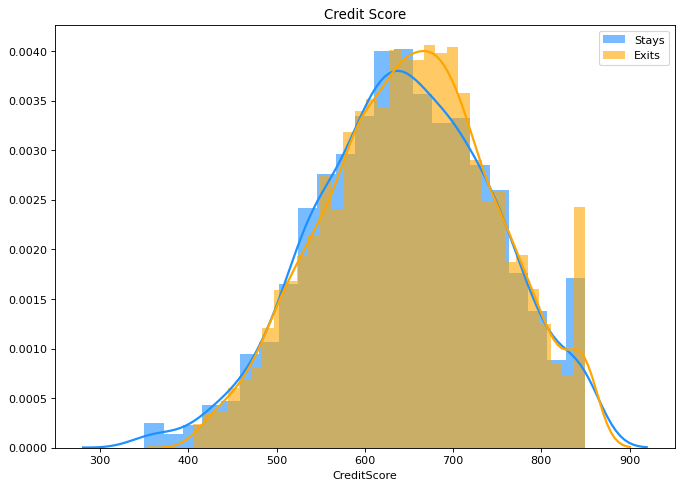

In [110]:
stays = churning_data.loc[churning_data.Exited == 1, 'CreditScore']
exits = churning_data.loc[churning_data.Exited == 0, 'CreditScore']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(stays, color="dodgerblue", label="Stays", **kwargs).set_title("Credit Score")
sns.distplot(exits, color="orange", label="Exits", **kwargs)
plt.legend();

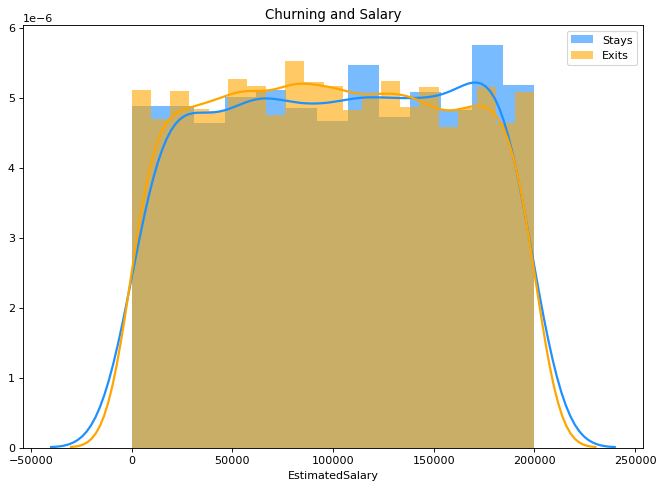

In [111]:
stays = churning_data.loc[churning_data.Exited == 1, 'EstimatedSalary']
exits = churning_data.loc[churning_data.Exited == 0, 'EstimatedSalary']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(stays, color="dodgerblue", label="Stays", **kwargs).set_title("Churning and Salary")
sns.distplot(exits, color="orange", label="Exits", **kwargs)
plt.legend();

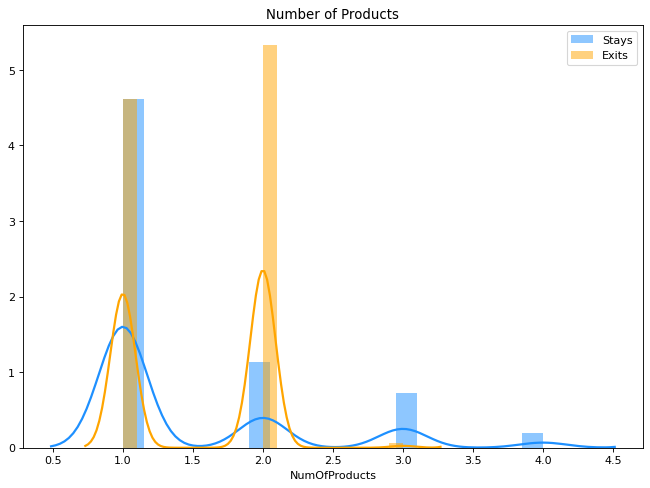

In [112]:
stays = churning_data.loc[churning_data.Exited == 1, 'NumOfProducts']
exits = churning_data.loc[churning_data.Exited == 0, 'NumOfProducts']

kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(stays, color="dodgerblue", label="Stays", **kwargs).set_title("Number of Products")
sns.distplot(exits, color="orange", label="Exits", **kwargs)

plt.legend();

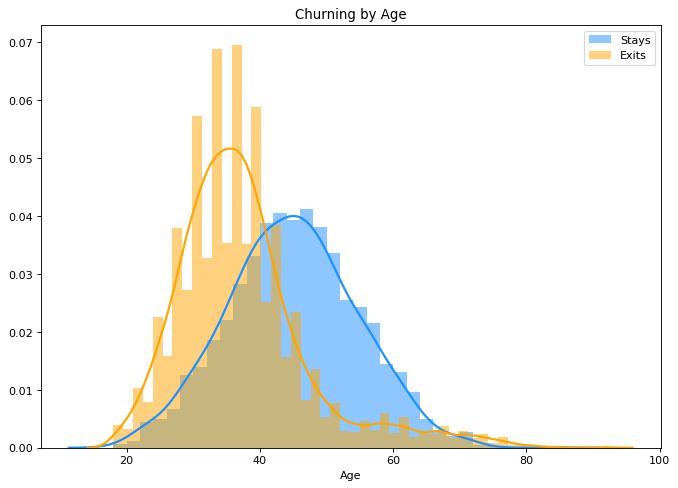

In [113]:
stays = churning_data.loc[churning_data.Exited == 1, 'Age']
exits = churning_data.loc[churning_data.Exited == 0, 'Age']

kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(stays, color="dodgerblue", label="Stays", **kwargs).set_title('Churning by Age')
sns.distplot(exits, color="orange", label="Exits", **kwargs)

plt.legend();


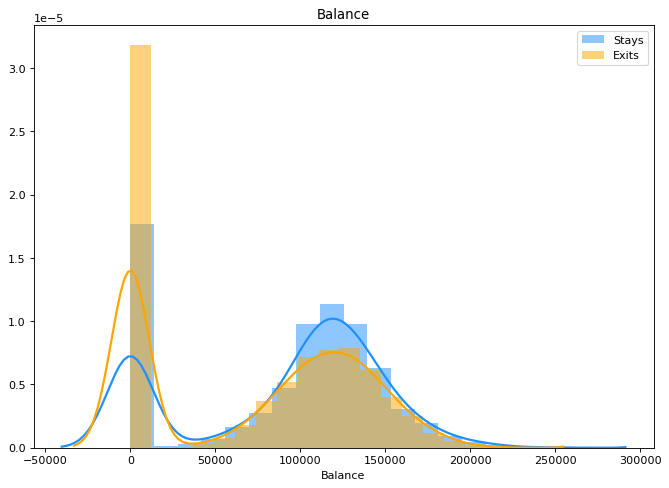

In [114]:
stays = churning_data.loc[churning_data.Exited == 1, 'Balance']
exits = churning_data.loc[churning_data.Exited == 0, 'Balance']

kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(stays, color="dodgerblue", label="Stays", **kwargs).set_title('Balance')
sns.distplot(exits, color="orange", label="Exits", **kwargs)

plt.legend();

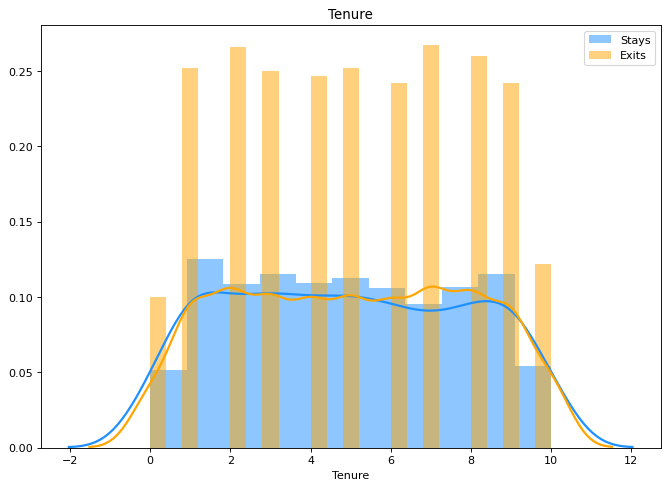

In [115]:
stays = churning_data.loc[churning_data.Exited == 1, 'Tenure']
exits = churning_data.loc[churning_data.Exited == 0, 'Tenure']

kwargs = dict(hist_kws={'alpha':.5}, kde_kws={'linewidth':2})

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(stays, color="dodgerblue", label="Stays", **kwargs).set_title('Tenure')
sns.distplot(exits, color="orange", label="Exits", **kwargs)

plt.legend();

Data is split into trainging and test sets (70/30) percent.

In [116]:
## data info. 
label_encoder = LabelEncoder()
## Categorical data encoding , Gender , Geography. 
churning_data['Gender'] = label_encoder.fit_transform(churning_data['Gender']) ## Gender (Female , Male)
churning_data['Geography'] = label_encoder.fit_transform(churning_data['Geography']) ## Geography (France , Spain ...etc)

## predictors : Credit Score , Geography , Gender , Age , Tenure , Balance , NumOfProducts , HasCrCard , IsActiveMember , EstimatedSalary
X = churning_data[['CreditScore' , 'Geography' , 'Gender' , 'Age' , 'Tenure' , 'Balance' , 'NumOfProducts' , 'HasCrCard' , 'IsActiveMember' , 'EstimatedSalary']]

## dependent variable , "Exited"
y = churning_data[['Exited']]

## Split data into training and test sets. Use following proportions  train 70% and test 30%
X_train, X_test, y_train, y_test =  train_test_split (X , y , test_size=0.3 , random_state = 42)

positives = churning_data[churning_data['Exited'] == 1]
positivePercent = len(positives) / len(churning_data)
print("Positive (exited = 1) in Null model  : " + str(positivePercent))
print("Negatives (exited = 0) in Null model  : " + str(1 - positivePercent))


positivesTest = y_test[y_test['Exited'] == 1]
positivePercentTest = len(positivesTest) / len(X_test)
print("Positive (exited = 1) in Null model on test data  : " + str(positivePercentTest))
print("Negatives (exited = 0) in Null model on test data  : " + str(1 - positivePercentTest))



Positive (exited = 1) in Null model  : 0.2037
Negatives (exited = 0) in Null model  : 0.7963
Positive (exited = 1) in Null model on test data  : 0.19466666666666665
Negatives (exited = 0) in Null model on test data  : 0.8053333333333333


**The null model (Model without any predictors) tends to predict that majority of employees stay with 80% probability.**

Confusion Matrix of LR without regularization
True Negatives : 2354
True Positives : 48
False Positives : 62
False Negatives : 536
Logistic Regression model Performance on test data
Sensitivity : 0.0821917808219178
Specificity : 0.9743377483443708
Accuracy : 0.8006666666666666
Precision : 0.43636363636363634
Recall : 0.0821917808219178
Mathew Accuracy : 0.1190926592435375
AUC Score : 0.5282647645831442


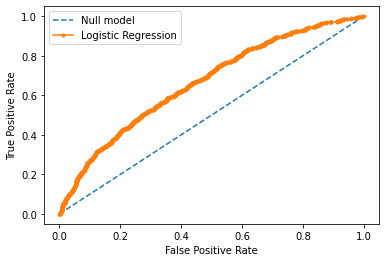

In [117]:
lr1 = LogisticRegression()
lr1.fit(X_train , y_train.values.ravel())

y_test_pred1 = lr1.predict(X_test)
printConfusionMatrix ("Confusion Matrix of LR without regularization" , y_test , y_test_pred1)
performanceTest = getModelPerformance (y_test , y_test_pred1)
printPerformanceData("Logistic Regression model Performance on test data" , performanceTest)
lr_probs = lr1.predict_proba(X_test)[:, 1]
lr1_score = metrics.roc_auc_score(y_test, y_test_pred1)
print ('AUC Score : ' + str(lr1_score))
plotLR_ROC((1-positivePercent) , lr_probs , y_test , X_test , "Logistic Regression")


This model has high accuracy but low Mathew's accuracy because the data is not distributed evenly on the two classes , it is bad in predicting true positives (People who leave their jobs) but doing better with true negatives (people who stay) which is the trend which predicts the null model. This model is not useful and we should try to improve it by scaling the data ,  using regularization , trying different solver. In the model below we'll try to use liblinear solver and tackle the imbalance by using class_weight = 'balanced'

Confusion Matrix of LR , balanced on test data
True Negatives : 1570
True Positives : 389
False Positives : 846
False Negatives : 195
Logistic Regression model Performance on test data
Sensitivity : 0.666095890410959
Specificity : 0.6498344370860927
Accuracy : 0.653
Precision : 0.31497975708502024
Recall : 0.666095890410959
Mathew Accuracy : 0.2541794130852269
AUC Score : 0.6579651637485259


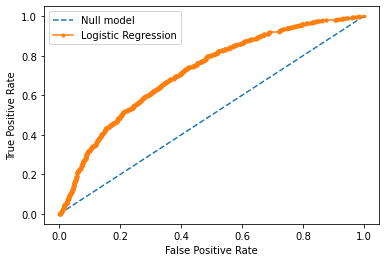

In [118]:
lr2 = LogisticRegression( penalty='l2' , C=1 , class_weight='balanced' , solver='liblinear')
lr2.fit(X_train , y_train.values.ravel())

y_test_pred2 = lr2.predict(X_test)
printConfusionMatrix ("Confusion Matrix of LR , balanced on test data" , y_test , y_test_pred2)
performanceTest2 = getModelPerformance (y_test , y_test_pred2)
printPerformanceData("Logistic Regression model Performance on test data" , performanceTest2)
lr_probs = lr2.predict_proba(X_test)[:, 1]
lr2_score = metrics.roc_auc_score(y_test, y_test_pred2)
print ('AUC Score : ' + str(lr2_score))
plotLR_ROC((1-positivePercent) , lr_probs , y_test , X_test , "Logistic Regression")


The resulting model is better in terms of higher true positives but at the expense of introducing high number of false positives and lower true negatives. Accuracy has dropped due to increase in errors coming from lower true negatives. 

By using a different threshold we can balance the error a little bit as shown below where I chose threshold of 0.55

In [119]:
lr2 = LogisticRegression( penalty='l2' , C=1 , class_weight='balanced' , solver='liblinear')
lr2.fit(X_train , y_train.values.ravel())

lr_probs = lr2.predict_proba(X_test)[:, 1]

threshold = 0.55

y_test_pred2 = lr_probs > threshold
printConfusionMatrix ("Confusion Matrix of LR , balanced on test data" , y_test , y_test_pred2)
performanceTest2 = getModelPerformance (y_test , y_test_pred2)
printPerformanceData("Logistic Regression model Performance on test data" , performanceTest2)
lr2_score = metrics.roc_auc_score(y_test, y_test_pred2)
print ('AUC Score : ' + str(lr2_score))


Confusion Matrix of LR , balanced on test data
True Negatives : 1809
True Positives : 322
False Positives : 607
False Negatives : 262
Logistic Regression model Performance on test data
Sensitivity : 0.5513698630136986
Specificity : 0.7487582781456954
Accuracy : 0.7103333333333334
Precision : 0.34660925726587727
Recall : 0.5513698630136986
Mathew Accuracy : 0.2570180951328389
AUC Score : 0.6500640705796971




Now I will move to classification tree to see if we can obtain more accurate model. I used grid search to choose optimal tree depth. 

tuned hpyerparameters :(best parameters) {'criterion': 'gini', 'max_depth': 5}
Confusion Matrix of Classification Tree on Test Data 
True Negatives : 2370
True Positives : 200
False Positives : 46
False Negatives : 384
Classification trees model's Performance on test data
Sensitivity : 0.3424657534246575
Specificity : 0.9809602649006622
Accuracy : 0.8566666666666667
Precision : 0.8130081300813008
Recall : 0.3424657534246575
Mathew Accuracy : 0.4667456953130868
AUC Score : 0.66171300916266


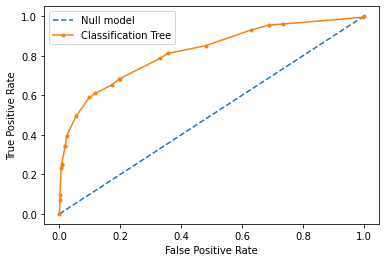

In [120]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 10)}    
ct = tree.DecisionTreeClassifier()   
ct_gscv = GridSearchCV(ct, param_grid, cv=20)    
ct_gscv.fit(X_train, y_train)
print ("tuned hpyerparameters :(best parameters) " + str(ct_gscv.best_params_))

y_test_pred4 = ct_gscv.predict(X_test)
printConfusionMatrix ("Confusion Matrix of Classification Tree on Test Data " , y_test , y_test_pred4)
performanceTest4 = getModelPerformance (y_test , y_test_pred4)
printPerformanceData("Classification trees model's Performance on test data" , performanceTest4)
ct_probs = ct_gscv.predict_proba(X_test)[:, 1]
ct_score = metrics.roc_auc_score(y_test, y_test_pred4)
print ('AUC Score : ' + str(ct_score))
plotLR_ROC((1-positivePercent) , ct_probs , y_test , X_test , "Classification Tree")


The tree model is obviously good in predicting the true positives but not as good as the last logistic regression . We can choose different thresholds to balance the results as in the code below , I tried with different valuse and used 0.3 . 


In [121]:
param_grid = { 'criterion':['gini','entropy'],'max_depth': np.arange(3, 10)}    
ct = tree.DecisionTreeClassifier()   
ct_gscv = GridSearchCV(ct, param_grid, cv=20)    
ct_gscv.fit(X_train, y_train)
print ("tuned hpyerparameters :(best parameters) " + str(ct_gscv.best_params_))

threshold = 0.3
ct_probs = ct_gscv.predict_proba(X_test)[:, 1]
y_test_pred4 = ct_probs > threshold
printConfusionMatrix ("Confusion Matrix of Classification Tree on Test Data " , y_test , y_test_pred4)
performanceTest4 = getModelPerformance (y_test , y_test_pred4)
printPerformanceData("Classification trees model's Performance on test data" , performanceTest4)
ct_score = metrics.roc_auc_score(y_test, y_test_pred4)
print ('AUC Score : ' + str(ct_score))

tuned hpyerparameters :(best parameters) {'criterion': 'gini', 'max_depth': 5}
Confusion Matrix of Classification Tree on Test Data 
True Negatives : 2176
True Positives : 345
False Positives : 240
False Negatives : 239
Classification trees model's Performance on test data
Sensitivity : 0.5907534246575342
Specificity : 0.9006622516556292
Accuracy : 0.8403333333333334
Precision : 0.5897435897435898
Recall : 0.5907534246575342
Mathew Accuracy : 0.4910971281265285
AUC Score : 0.7457078381565817


In the last model I will use random forest and will see if we can beat the last model of classification tree with threshold 0.3 

Confusion Matrix of random forest on test data
True Negatives : 2041
True Positives : 395
False Positives : 375
False Negatives : 189
Random forest model's Performance on test data
Sensitivity : 0.6763698630136986
Specificity : 0.8447847682119205
Accuracy : 0.812
Precision : 0.512987012987013
Recall : 0.6763698630136986
Mathew Accuracy : 0.47241501862048674
AUC Score : 0.7605773156128095


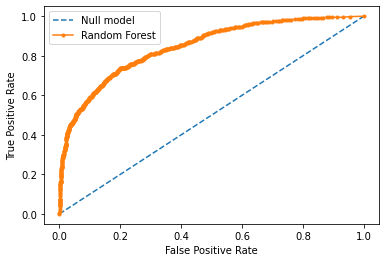

In [122]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train.values.ravel());

y_test_pred5 = rf.predict(X_test) >= 0.3
printConfusionMatrix ("Confusion Matrix of random forest on test data" , y_test , y_test_pred5)
performanceTest5 = getModelPerformance (y_test , y_test_pred5)
printPerformanceData("Random forest model's Performance on test data" , performanceTest5)
rf_prob = rf.predict(X_test)
rf_score = metrics.roc_auc_score(y_test, y_test_pred5)
print ('AUC Score : ' + str(rf_score))
plotLR_ROC((1-positivePercent) , rf_prob , y_test , X_test , "Random Forest")
